In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import PIL
image = PIL.Image.open("/content/drive/MyDrive/train/pneumonia/CXR_train_1.png")
width, height = image.size
print(width, height)

1024 1024


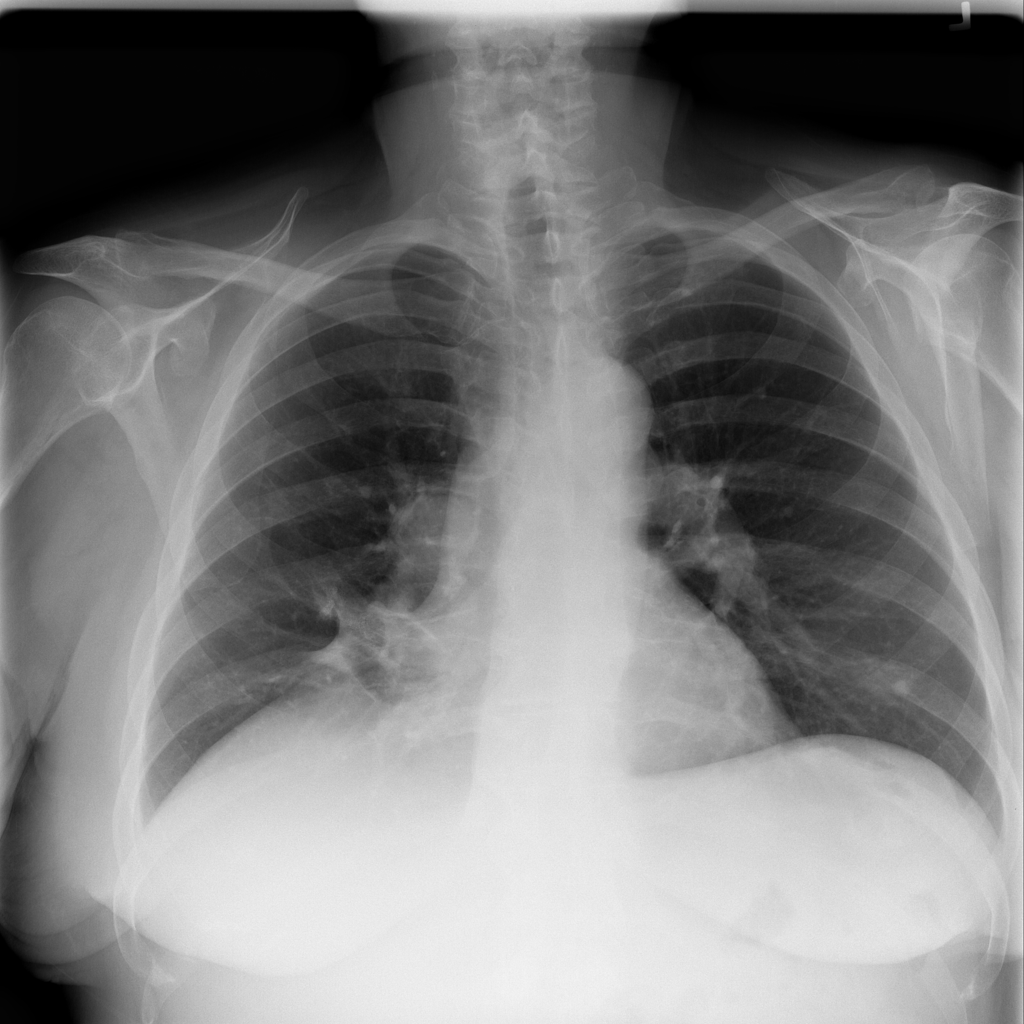

In [22]:
im = PIL.Image.open("/content/drive/MyDrive/train/pneumonia/CXR_train_1.png")
im

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn                             

In [24]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

In [25]:
train_generator=datagen.flow_from_directory(
directory="/content/drive/MyDrive/train",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(224,224))

Found 1940 images belonging to 2 classes.


In [26]:
val_generator=datagen.flow_from_directory(
directory="/content/drive/MyDrive/train",
subset="validation",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(224,224))

Found 485 images belonging to 2 classes.


In [27]:
train_classes = train_generator.classes
print(train_classes)

[0 0 0 ... 1 1 1]


In [28]:
# To get the class names i.e if the name of the folders are the names of the classes and their respective indices
train_generator.class_indices

{'normal': 0, 'pneumonia': 1}

In [29]:
# To the class mode i.e if it is Binary or Multilabel classification
train_generator.class_mode

'binary'

**Initializing the base model**

In [30]:
image_size = 224
IMG_SHAPE = (image_size, image_size, 3)
#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Adding Extra layers to Pre-trained Model

In [31]:
model = tf.keras.Sequential([base_model,keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.3),
                             keras.layers.Dense(1, activation='sigmoid')])

**Compiling the model**

In [32]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Callbacks**

In [33]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nReached 92% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

**Training the model**

In [34]:
initial_epochs = 15

In [35]:
history = model.fit(train_generator, epochs= initial_epochs, 
                    validation_data=val_generator)

Epoch 1/15
61/61 [==============================] - 48s 732ms/step - loss: 0.7953 - accuracy: 0.4907 - val_loss: 0.6795 - val_accuracy: 0.5732
Epoch 2/15
61/61 [==============================] - 44s 722ms/step - loss: 0.7376 - accuracy: 0.5438 - val_loss: 0.6568 - val_accuracy: 0.6041
Epoch 3/15
61/61 [==============================] - 43s 710ms/step - loss: 0.7431 - accuracy: 0.5479 - val_loss: 0.6423 - val_accuracy: 0.6289
Epoch 4/15
61/61 [==============================] - 43s 711ms/step - loss: 0.7073 - accuracy: 0.5753 - val_loss: 0.6300 - val_accuracy: 0.6474
Epoch 5/15
61/61 [==============================] - 44s 715ms/step - loss: 0.7043 - accuracy: 0.5851 - val_loss: 0.6241 - val_accuracy: 0.6454
Epoch 6/15
61/61 [==============================] - 43s 712ms/step - loss: 0.6914 - accuracy: 0.5881 - val_loss: 0.6158 - val_accuracy: 0.6701
Epoch 7/15
61/61 [==============================] - 43s 707ms/step - loss: 0.6916 - accuracy: 0.6072 - val_loss: 0.6113 - val_accuracy: 0.6845

**Visualizing the training and Validation performance**

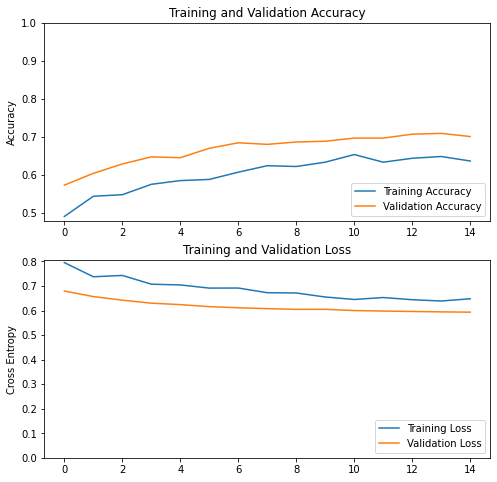

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()